In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.lax import fori_loop as jfori
from functools import partial
import pyext.src.plot as plot
from typing import Any
from sklearn.metrics import roc_curve, precision_recall_curve
import inspect
import re
State = Any
Output = Any
KeyArray = Any
DeviceArray = Any

In [2]:
class StateLess:
    def stateless_method(state: State, *args, **kwargs) -> (State, Output):
        pass

# Funcitonal implementation
def cond_norm(key, y, rho, *args, **kwargs):
    return jax.random.normal(key) * jnp.sqrt(1 - rho **2) + y * rho

def cond_bern(key, p, shape):
    return jax.random.bernoulli(key, p, shape)

"""
def cond_bern(key, i, state, args):
    x = jax.random.bernoulli(key, args)
    state = state.at[i].set(x)
    return state
"""

    
def cond_dist(key, dist, params, **kwargs):
    return dist(key, *params, **kwargs)


# X and Y are independant


def gibbsf(key: KeyArray, *args, N=10, thin=10,
           rho=0.5, dof=2,
           **kwargs) -> DeviceArray:
    
    def outer_body_fun(i: int, val):
        key, samples, params, rho, thin  = val
        key, samples, params, rho, thin = jax.lax.fori_loop(0, thin, inner_body_fun, val)
        samples = samples.at[i].set(params)
        return key, samples, params, rho, thin

    def inner_body_fun(i: int, 
                       init_val
                       ) -> tuple[KeyArray, float, float]:
        
        key, samples, params, rho, thin = init_val
        key, k1, k2 = jax.random.split(key, 1 + dof)
        # x = jax.random.normal(k1) * jnp.sqrt(1 - rho **2) + y * rho
        # y = jax.random.normal(k2) * jnp.sqrt(1 - rho **2) + x * rho
        x = jax.random.bernoulli(k1, 0.5)
        y = jax.random.bernoulli(k2, 0.5)
        
        
        
        
        params = [x, y]
        return key, samples, params, rho, thin
    
    # initiate
    key, k1, k2 = jax.random.split(key, 3)
    # x = jax.random.uniform(k1)
    # y = jax.random.uniform(k2)
    
    x = jax.random.bernoulli(k1)
    y = jax.random.bernoulli(k2)
    
    samples = jnp.zeros((N, 2))
    params = [x, y]
    val = key, samples, params, rho, thin
    
    # key, samples, x, y, rho, thin
    samples = jax.lax.fori_loop(0, N, outer_body_fun, val)[1]
    return samples

In [3]:
# imperative implementation
def gibbs(key, N=10, thin=10):
    key, k1, k2 = jax.random.split(key, 3)
    x = jax.random.uniform(k1)
    y = jax.random.uniform(k2)
    samples = jnp.array(np.zeros((N, 2)))
    for i in range(N):
        for j in range(thin):
            key, k1, k2 = jax.random.split(key, 3)
            x = x_cond_dens(k1, y)
            y = y_cond_dens(k2, x)
        samples = samples.at[i].set([x, y])
    return samples

In [4]:
#Block defines meta programmig conventions for dynamically defined
#functions used with the jax jit compiler
from typing import NewType
PyFname = NewType('MPyFname', str)  # sybolic id (name) of a function
PyFdef = NewType('MPyFdef', str)  # string rep of python function definition
PyFargs = NewType('MPyFargs', str) # string rep of python funciton arguments

PyObj = NewType('MPyObj', str)   # string rep of a python object
PyStmnt = NewType('MPyObj', str)  # string rep of a python statment
PyBlock = NewType('MPyBlock', str)  # string rep of a block of statements

PyExpr = NewType('MPyExpr', str)  # string rep of a python expression
PyCname = NewType('MPyCname', str)  # symbolic id (name) of a class
PyCdef = NewType('MPyCdef', str) # string rep of python class definition

PyLit = NewType('PyLit', str)  # string rep of python literal e.g., '2'
PyIden = NewType('PyIden', str)  # string rep of python identifier e.g. 'map'
PyOp = NewType('PyOp', str)  # string rep of python operator e.g., '+', '('

#cond_bern_str : PyFdef = """def cond_bern(key, i, state, args):
#    x = jax.random.bernoulli(key, args)
#    state = state.at[i].set(x)
#    return state"""

class PyFunction:
    def __init__(self, 
                 name : PyFname = "",
                 args : PyStmnt = "",
                 ret = "",
                 ret_t = "",
                 body = "",
                 offset : int = 0):
        self.args = args
        self.name = name
        self.ret = ret
        self.ret_t = ret_t
        self.offset = offset
        self.body = body
    
    def define(self) -> PyFdef:
        fs = ' ' * self.offset + f'def {self.name}({self.args}) -> {self.ret_t}:'
        
        return fs

In [5]:
def offset_str(off: int, s: str, newline = True) -> str:
    s = ' ' * off + s
    if newline:
        return s + '\n'
    else:
        return s
    
def define_inner_body_fun():
    def inner_body_fun(i : int,
                       init_val) -> tuple[KeyArray, float, float]:
        pass
    
    def stmnt():
        (key, *k) = jax.random.split(key, 1 + {dof})
    ss = inspect.getsource(stmnt)
    fs = inspect.getsource(inner_body_fun)
    return fs, ss
    
def get_paramlist_str(dof : int) -> PyObj:
    start = '['
    for i, j in enumerate(range(dof)):
        start +=  f'x{j}, '
    start = start.strip(', ')
    start+= ']'
    return start

def py_compile_inner_body(f : PyFname , 
                          dof : int , 
                          offset : int = 0,
                          comma_seperated_values="") -> PyFdef:
    
    
    c = """"""
    o = partial(offset_str, offset)
    c += o("""def inner_body_fun(i: int,
                   init_val) -> tuple[KeyArray, float, float]:\n""")
    c+= o(f"""    {comma_seperated_values} = init_val""")
    c+= o(f"""    (key, *k) = jax.random.split(key, 1 + {dof})""")
    
    
    param_list = offset_str(offset, '[', newline=False)
    
    
    for i, j in enumerate(range(dof)):
        c+=o(f'    x{j} = {f}(k[{j}])')
        param_list += f'x{j}, '
    param_list = param_list.strip(', ')
    param_list +=']'
    c+=o(f'    params = {param_list}')
    c+=o( f'    return {comma_seperated_values}')
    
    #c = inspect.getsource(inner_body_fun)
    #pattern = 'key, samples, params, rho, thin'
    #repl = '{comma_seperated_values}'
    #c = re.sub(pattern, repl, source)
    
    return c

#print(py_compile_inner_body('jax.random.bernoulli', 10))

def py_compile_outer_body(dof, offset=0,
                         comma_seperated_values="") -> PyFdef:
    
    o = partial(offset_str, offset)
    c=''
    c+=o("""def outer_body_fun(i: int, val):\n""")
    o = partial(offset_str, 4 + offset)
    c+=o(f"""{comma_seperated_values} = val""")
    c+=o(f"""{comma_seperated_values} = jax.lax.fori_loop(0, thin, inner_body_fun, val)""")
    c+=o("""samples = samples.at[i].set(params)""")
    # c+=o(f"""val = {comma_seperated_values}""")
    c+=o(f"""return {comma_seperated_values}""")
    return c

def py_compile_initialize(init_function_str, dof, 
                         offset=0,
                         comma_seperated_values="",
                         N=5000) -> PyBlock:
        # initiate
    c=""""""
    o = partial(offset_str, offset)
    # c = OffsetStr(offset=offset)
    c+=o(f'(key, *k) = jax.random.split(key, {1 + dof})')
    param_list = '['
    for i, j in enumerate(range(dof)):
        c+=o(f'x{j} = {init_function_str}(k[{j}])')
    param_list += f'x{j}, '
    param_list_str = get_paramlist_str(dof)
    c+=o(f'samples = jnp.zeros(({N}, {dof}))')
    c+=o(f'params = {param_list_str}')
    c+=o(f'val = {comma_seperated_values}')
    c+=o('samples = jax.lax.fori_loop(0, N, outer_body_fun, val)[1]')
    c+=o('return samples')
    
    return c

    
    #val = key, samples, params, rho, thin
    
    # key, samples, x, y, rho, thin
    #samples = jax.lax.fori_loop(0, N, outer_body_fun, val)[1]

def compile_gibbsf(init_f : PyFname, 
                   f_str : PyFname,
                   definitions : PyBlock = "",
                   offset : int = 4,
                   thin : int = 10,
                   N : int = 5000,
                   rho : float = 0.5,
                   dof : int = 3) -> PyFdef:
    
    comma_seperated_values = 'key, samples, params, rho, thin'
    
    o = partial(offset_str, 0)

    c=o(f"""def gibbsf(key: KeyArray, *args, N={N}, thin={thin},
           rho={rho}, dof={dof},
           **kwargs) -> DeviceArray:\n""")
    c+=o(f"""{py_compile_outer_body(dof, offset=offset,
                                  comma_seperated_values=comma_seperated_values)}\n""")
    c+=o(f"""{py_compile_inner_body(f_str, dof, offset=offset,
                                  comma_seperated_values=comma_seperated_values)}\n""")
    c+=o(f"""{py_compile_initialize(init_f, dof, offset=offset, N=N,
                                  comma_seperated_values = comma_seperated_values)}\n""")
    
    m="""### Meta python func BEGIN ###\n"""
    m+= c
    m+= """### Meta python func END ###\n"""
    return m

In [6]:
N = 5000
thin = 100
dof = 2
rho=-0.99

init_func = 'jax.random.bernoulli'
func = 'jax.random.bernoulli'
#init_func = 'jax.random.normal'
#func = 'jax.random.normal'

#init_func = 'cond_norm'
#func = 'cond_norm'

#init_func = cond_bern_str
#func = 'cond_bern'


init_sig = ''
func_sig = ''
inter_rep = compile_gibbsf(init_func, func, N=N, dof=dof, 
                           thin=thin, rho=rho)

#Exec brings the meta function gibbsf into the global scope
exec(inter_rep)
gibbsf_jaxpr = jax.make_jaxpr(gibbsf)
gibbsf_jit = jax.jit(gibbsf)

In [7]:
print(compile_gibbsf(init_func, func, N=N, dof=dof, 
                           thin=thin, rho=rho))

### Meta python func BEGIN ###
def gibbsf(key: KeyArray, *args, N=5000, thin=100,
           rho=-0.99, dof=2,
           **kwargs) -> DeviceArray:

    def outer_body_fun(i: int, val):

        key, samples, params, rho, thin = val
        key, samples, params, rho, thin = jax.lax.fori_loop(0, thin, inner_body_fun, val)
        samples = samples.at[i].set(params)
        return key, samples, params, rho, thin


    def inner_body_fun(i: int,
                   init_val) -> tuple[KeyArray, float, float]:

        key, samples, params, rho, thin = init_val
        (key, *k) = jax.random.split(key, 1 + 2)
        x0 = jax.random.bernoulli(k[0])
        x1 = jax.random.bernoulli(k[1])
        params = [x0, x1]
        return key, samples, params, rho, thin


    (key, *k) = jax.random.split(key, 3)
    x0 = jax.random.bernoulli(k[0])
    x1 = jax.random.bernoulli(k[1])
    samples = jnp.zeros((5000, 2))
    params = [x0, x1]
    val = key, samples, params, rho, thin
    samples = jax.lax.

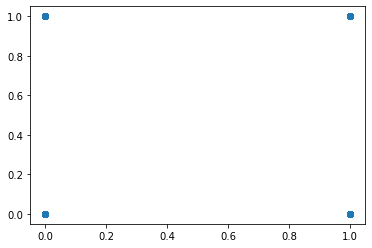

In [8]:
def make_gibbs_jit(sampler, rho, N, thin, dof):
    gibbsf_partial = partial(sampler, N=N, 
                             thin=thin, rho=rho,
                             dof=dof)
    gibbsf_jit = jax.jit(gibbsf_partial)
    return gibbsf_jit

# gibbsf_jit = make_gibbs_jit(gibbsf, 0.99, 5000, 100, 2)
# gibbsf_jit  = jax.jit(gibbsf)
key = jax.random.PRNGKey(12)
samples = np.array(gibbsf_jit(key))
x, y = samples[:, 0], samples[:, 1]
plot.scatter(x, y)

In [9]:
print(f'{samples.size * 32 / 10**6} megabytes')

0.32 megabytes


In [10]:
def get_probability_estimates(samples):
    return jnp.mean(samples, axis=0)

In [11]:
prob_estimate = get_probability_estimates(samples)

In [12]:
# Plot ROC and PRC curves
def ROC_PRC_test():
    key = jax.random.PRNGKey(10298)
    key, k1 , k2 = jax.random.split(key, 3)
    shape = (1000000, )
    y_true = jax.random.bernoulli(key, p=0.01, shape=shape)
    score = jax.random.uniform(k1, shape=shape)
    fpr, tpr, thresholds = roc_curve(y_true, score)
    precision, recall, pthresholds = precision_recall_curve(y_true, score)
    return fpr, tpr, thresholds, precision, recall, pthresholds

In [13]:
val = ROC_PRC_test()
fpr, tpr, thre, prec, recall, pthre = val

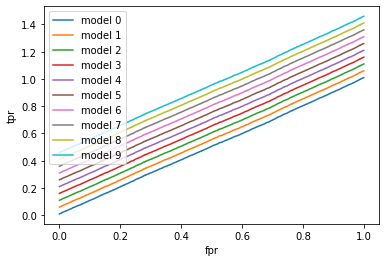

In [14]:
def multi_plot(fpr, tpr, xlabel='fpr', ylabel='tpr'):
    labels = []
    for e, i in enumerate(np.arange(0.01, 0.5, 0.05)):
        xi = tpr + i
        plt.plot(fpr, xi)
        label = f'model {e}'
        labels.append(label)
    plt.legend(labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

multi_plot(fpr, tpr)

/home/aji/anaconda3/envs/pynetp3.10.0/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


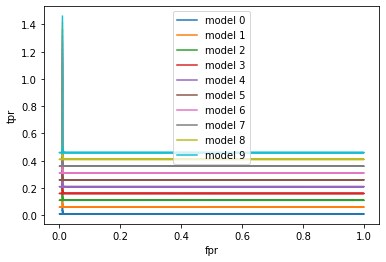

In [15]:
multi_plot(prec, recall)

In [16]:
def f3(k1, x):
    k1, k2 = jax.random.split(k1)
    n, x = f2(k1, x)
    u, x = f1(k2, x)
    return u, x
f3(testkey, 2)

NameError: name 'testkey' is not defined

In [ ]:
%%bash
conda list scikit-learn

In [ ]:
samples = gibbsf_jit(key, rho=0)
plot.scatter(samples[:, 0], samples[:, 1])

In [ ]:
plot.marginal(x, xlabel='x')

In [ ]:
plot.marginal(y, xlabel='y')

In [ ]:
# Metropolis Hastings


def mh_f(key, steps):
    
    def score(x):
        return jax.scipy.stats.logistic.pdf(x)

    def rv(key):
        return jax.random.uniform(key, minval=-10, maxval=10)

    def body(i, init):
        key, x = init
        x0 = x[i-1]
        key, g1, g2 = jax.random.split(key, 3)
        x1 = rv(g1)
        A = score(x1) / score(x0)
        p = jax.random.uniform(g2)
        xi = jax.lax.cond(p < A, lambda : x1, lambda : x0)
        x = x.at[i].set(xi)
        return key, x
    
    def silly(i, v):
        u, x = v
        w = u, x
        return w
    
    samples = jnp.zeros(steps)
    key, samples = jax.lax.fori_loop(1, steps, body, (key, samples))
    return samples

key = jax.random.PRNGKey(10)
key, j1 = jax.random.split(key, 2)
steps = 100000
mh_f(key, steps)

In [ ]:
%timeit mh_f(key, steps)

In [ ]:
mh_fp = partial(mh_f, steps=100000)

In [ ]:
mh_f_p_jit = jax.jit(mh_fp)

In [ ]:
%timeit mh_f_p_jit(key).block_until_ready()

In [ ]:
jnp.all(mh_fp(key) == mh_f_p_jit(key))

In [ ]:
x = np.array(mh_f_p_jit(key))
plot.marginal(x)

In [ ]:
s = np.array(score(x))
plot.marginal(s)

In [ ]:
np.quantile(x, np.arange(0, 1, 0.1))

In [ ]:
np.arange(0, 1, 0.1)

In [ ]:
k1 = jax.random.PRNGKey(23)
k2 = jax.random.PRNGKey(23)

In [ ]:
%timeit gibbsf_jit(k1).block_until_ready()

In [ ]:
%timeit gibbs(k2, N=5000, thin=100)

In [ ]:
def rel_error(x, s):
    return s / x

def error():
    r1 = rel_error(0.160, 0.0177)
    r2 = rel_error(59.9, 0.0373)
    r3 = r1 + r2
    return (59.9 / 0.160 ) * r3

jit:    160 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
python: 59.9 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

jit compilation appeared to accelerate the gibbs sampler by 374 ± 42

In [ ]:
jax.make_jaxpr(f)

In [ ]:
"""
# This code will take a very long time to jit compile
# because the gibbs function uses python for loops
# instead of jax.lax.fori_loop

gibbs_partial = partial(gibbs, N=50000, thin=1000)
gibbs_jit = jax.jit(gibbs_partial)
key = jax.random.PRNGKey(5)
samples = np.array(gibbs_jit(key))
plot.scatter(samples[:, 0], samples[:, 1])
"""

In [ ]:
key = jax.random.PRNGKey(5)
gibbs_jit = jax.jit(gibbs)
samples = gibbs_jit(key)

In [ ]:
key = jax.random.PRNGKey(5)
gibbsf_jit = jax.jit(gibbsf)
samplesf = gibbsf_jit(key)

In [ ]:
key2 = jax.random.PRNGKey(17)
samples = gibbs_jit(key2)
key2 = jax.random.PRNGKey(17)
samplesf = gibbsf_jit(key2)

In [ ]:
plt.scatter(samplesf[:, 0], samplesf[:, 1])

In [ ]:
gibbs_partial = partial(gibbsf, N=50000, thin=1000)
gibbsf_jit = jax.jit(gibbs_partial)
key = jax.random.PRNGKey(5)
samples = np.array(gibbsf_jit(key))
plt.scatter(samples[:, 0], samples[:, 1])

In [ ]:
x, y, z, *args = (1, 2, 3)

In [ ]:
try:  # Doesn't work; fori_loop requires f(i, val)
    f = lambda x: x+1
    jax.lax.fori_loop(0, 100, f, 0)
except TypeError:
    # Works
    # Can jit through the funciton
    def iwrapper(f):
        def wrap(i, val):
            return f(val)
        return wrap
    f = iwrapper(lambda x: x+1)
    print(jax.lax.fori_loop(0, 10, f, 0))
    print(jax.jit(lambda : jax.lax.fori_loop(0, 10, f, 0))().block_until_ready())

In [ ]:
def f(x: KeyArray):
    def g(x):
        return 2*x
    return g(x) + 1
f = jax.jit(f)


In [ ]:
def inner_body_fun(i: int, 
                   val: tuple[KeyArray, float, float]
                   ) -> tuple[KeyArray, float, float]:

    key, samples, x, y, thin = val
    key, k1, k2 = jax.random.split(key, 3)
    x = x_cond_dens(k1, y)
    y = y_cond_dens(k2, x)
    samples = samples.at[i].set([x, y])
    return key, samples, x, y, thin

key = jax.random.PRNGKey(10)
key, k1, k2 = jax.random.split(key, 3)
N = 1000
thin = 5
x = jax.random.uniform(k1)
y = jax.random.uniform(k2)
samples = jnp.zeros((N, 2))
val = key, samples, x, y, thin
def outer(val):
    return jax.lax.fori_loop(0, N, inner_body_fun, val)

opartial = partial(outer, val=val)
otest = jax.jit(opartial)

In [ ]:
a, b, *args = (1, 2, 3)

In [ ]:
def f1(x, y, *args, **kwargs):
    return x * y, args, kwargs

def f2(x, *args, **kwargs):
    rho = kwargs['rho']
    return x + rho, args, kwargs

def g(x, y, *args, **kwargs):
    a, args, kwargs = f1(x, y, *args, **kwargs)
    b, args, kwargs = f2(a, *args, **kwargs)
    return b, args, kwargs

def h(x, y, *args, **kwargs):
    return f2(f1(*args, **kwargs))
g(1, 2, **{'rho': 4})

In [ ]:
# Suppose we have a set of functions a, b, c, ..., h
def local_block():
    def a(state: tuple[Any], x, y, *args, **kwargs):
        return state, (x + y, )

    def b(state: tuple[Any], x, *args, **kwargs):
        return state, (x, x ** 2 )

    def c(state: tuple[Any], x, y, *args, **kwargs):
        return state, (x + y, ), args, kwargs

    def d(state: tuple[Any], x, rho, *args, **kwargs):
        return state, (x - 10 * rho,)
    
    def e(state: tuple[Any], x, *args, **kwargs):
        return state, (x * 2, )
    
    def f(state: tuple[Any], x, *args, **kwargs):
        return state, (jnp.log(x), )
    
    def h(state: tuple[Any], x, *args, **kwargs):
        return state, (1 / 2 * x ** 2, )
    
    # We wish to compose and jit compile these functions into a pipe
    # output = h(e(d(c(b(a)))))
    # each function has positional[:tuple] and keyword[:dict] arguments
    # we would like to make a change in the middle of the chain without
    # affecting how we built the funciton before and after
    # how would we do this?
    
    # supposing the funcitons are pure
    
    # we must make a change to c
    # option1 : add an extra parameter to the highest level function
    # and a parameter to c without changing c's return type
    
    # c(x, y) -> c(x, y, z)
    # 
    
    def statless_function(state: State, *args, **kwargs) -> tuple[State, Output]:
        pass
    
    def pipe(state: tuple[Any], pipe_in, *args, **kwargs):
        state, return_a = a(state, *pipe_in)
        state, return_b = b(state, *return_a)
        state, return_c = c(state, *return_b)
        state, return_d = d(state, *return_c)
        state, return_e = e(state, *return_d)
        state, return_f = f(state, *return_e)
        state, pipe_out = h(state, *return_f)
        return state, pipe_out
    
    class P:
        def __lt__(self, div):
            print(div)
    
    state = (1, 2)
    pipe_in = (11, 12)
    p = P()
    p < pipe(state, pipe_in)
    #p < jax.make_jaxpr(a)((), np.array([1, 2]), np.array([1, 1]))
    p < jax.make_jaxpr(pipe)((1, 2), (11, 12))
    
        
local_block()

In [ ]:
def f(x, y, z, *args, file=None, **kwargs):
    print(file)
    return x, (y + z, ), args, kwargs

state, ret, args, kwargs = f(*(1, 2, 3, 4, 5), **{'j': 2, 'file':4})
state, ret, args, kwargs

In [ ]:
def f(state, *args, **kwargs):
    print(args)
    x = args[0]
    print(x)
    print(args)
    y = args[1]
    return args


def f(state, x, y, *args, **kwargs):
    ret_f = x + y
    return state_f, ret_f, args_f, kwargs_f


def producer(*args):
    return 1, 2

def middle(x, y, *args):
    print(x + y)
    print(args)
    return x + y, args
    
def consumer(z, *args):
    z = z**2
    print(z)
    print(args)
    return z



consumer(*middle(*producer()))

In [ ]:
def f1(x, y, *args, **kwargs):
    return x * y, args, kwargs

def f2(x, *args, **kwargs):
    return x + 2
print(jax.make_jaxpr(f2)b)

In [ ]:
jxp_f2 = jax.make_jaxpr(f2)

In [ ]:
jxp_f2

In [ ]:
g(1, 2, **{'rho': 10})

In [ ]:
def f(x, y, **kwargs):
    return x * y * rho

In [ ]:
f(1, 2, **{'rho':10})

In [ ]:
m[9]